In [37]:
import ee, geemap

In [38]:
ee.Authenticate()
ee.Initialize()

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import viz.corine as corine
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geemap
import rasterio
from rasterio.transform import from_origin



In [40]:
from habitat2 import run_lab2


In [41]:
lab2 = run_lab2()

df_umap = lab2["df_umap"]
emb_img = lab2["emb_img"]
AOI     = lab2["AOI"]
SCALE   = lab2["SCALE"]

In [42]:
emb_cols = [f"A{i:02d}" for i in range(64)]
label_col = "landcover_idx"

df_clean = df_umap.loc[~df_umap["is_outlier_rc"]].copy()

df_clean = df_clean.dropna(subset=emb_cols + [label_col])

X = df_clean[emb_cols].values.astype("float32")
y = df_clean[label_col].values.astype(int)

print("Clean dataset:", df_clean.shape)
print("Classes:", np.unique(y), " | n_classes =", len(np.unique(y)))


Clean dataset: (450, 72)
Classes: [112 142 211 231 242 243 311 312 313 511]  | n_classes = 10


In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (315, 64) Test: (135, 64)


In [44]:
df_distilled = df_umap.loc[~df_umap["is_outlier_rc"]].copy()

classes = sorted(df_distilled["landcover_idx"].unique().astype(int).tolist())
print("n_samples:", len(df_distilled))
print("classes:", classes)


n_samples: 450
classes: [112, 142, 211, 231, 242, 243, 311, 312, 313, 511]


In [45]:

def _to_hex(c):
    if isinstance(c, str):
        c = c.strip()
        if not c.startswith("#"):
            c = "#" + c
        return c
    return mcolors.to_hex(c)

color_map = {}

if hasattr(corine, "legend_dict") and isinstance(corine.legend_dict, dict):
    for k, v in corine.legend_dict.items():
        try:
            cls = int(k)
            color_map[cls] = _to_hex(v)
        except:
            pass

missing = [c for c in classes if c not in color_map]
if missing:
    cmap = plt.get_cmap("tab20", len(missing))
    for i, cls in enumerate(missing):
        color_map[cls] = mcolors.to_hex(cmap(i))

print("Colors prepared for classes:", len(color_map))


Colors prepared for classes: 10


In [46]:
models = {
    "KNN (k=15)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=15))
    ]),
    
    "Linear SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LinearSVC(C=1.0, max_iter=5000, random_state=42))
    ]),
    
    "RBF-SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(C=10.0, gamma="scale", kernel="rbf"))
    ]),
}


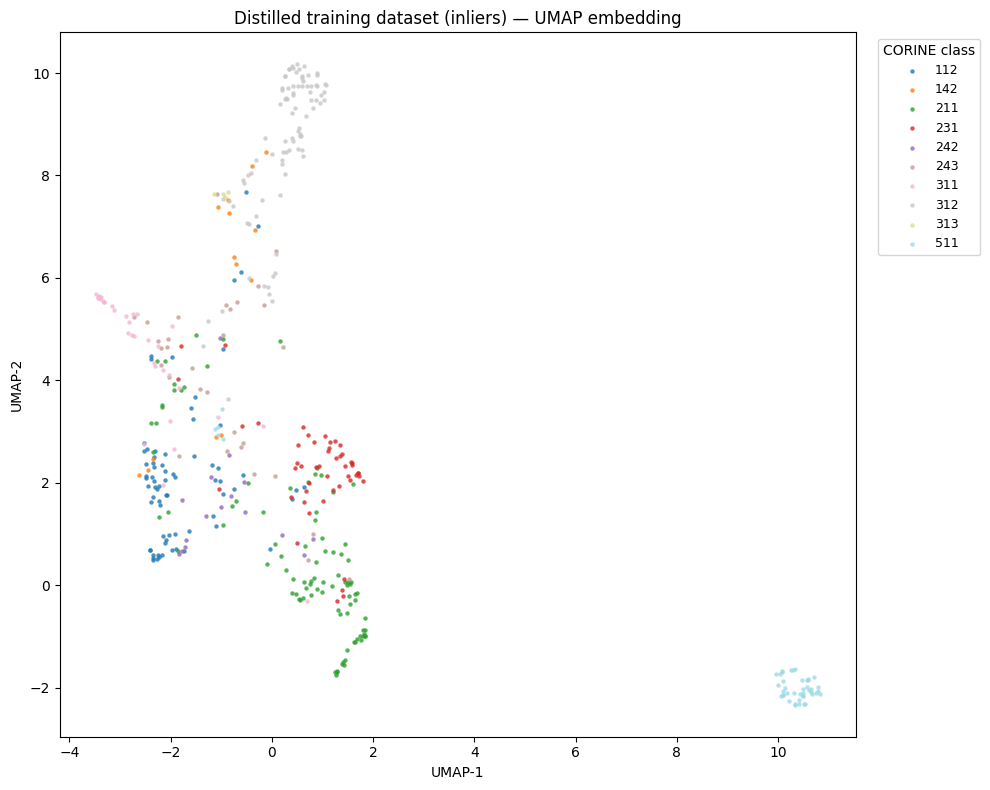

In [47]:
plt.figure(figsize=(10, 8))

for cls in classes:
    m = df_distilled["landcover_idx"].astype(int) == cls
    plt.scatter(
        df_distilled.loc[m, "umap1"],
        df_distilled.loc[m, "umap2"],
        s=10,
        alpha=0.8,
        c=color_map[cls],
        label=str(cls),
        linewidths=0
    )

plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("Distilled training dataset (inliers) — UMAP embedding")

leg = plt.legend(
    title="CORINE class",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=True,
    fontsize=9
)
plt.tight_layout()
plt.show()


In [48]:
results = []

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")  # macro-F1 = equal weight per class

    results.append({
        "model": name,
        "accuracy": acc,
        "macro_f1": f1m
    })

    print("\n" + "="*70)
    print(name)
    print("Accuracy:", acc)
    print("Macro-F1 :", f1m)
    print("\nClassification report:\n", classification_report(y_test, y_pred))

results_df = pd.DataFrame(results).sort_values("macro_f1", ascending=False).reset_index(drop=True)
results_df



KNN (k=15)
Accuracy: 0.7037037037037037
Macro-F1 : 0.49337590217808003

Classification report:
               precision    recall  f1-score   support

         112       0.60      0.82      0.69        22
         142       0.00      0.00      0.00         4
         211       0.63      0.79      0.70        28
         231       0.71      0.67      0.69        15
         242       1.00      0.20      0.33         5
         243       0.20      0.11      0.14         9
         311       0.67      0.40      0.50        10
         312       0.83      0.93      0.88        27
         313       0.00      0.00      0.00         1
         511       1.00      1.00      1.00        14

    accuracy                           0.70       135
   macro avg       0.56      0.49      0.49       135
weighted avg       0.68      0.70      0.67       135


Linear SVM
Accuracy: 0.7407407407407407
Macro-F1 : 0.6729119467277362

Classification report:
               precision    recall  f1-score   su

,model,accuracy,macro_f1
0,RBF-SVM,0.748148,0.674843
1,Linear SVM,0.740741,0.672912
2,KNN (k=15),0.703704,0.493376


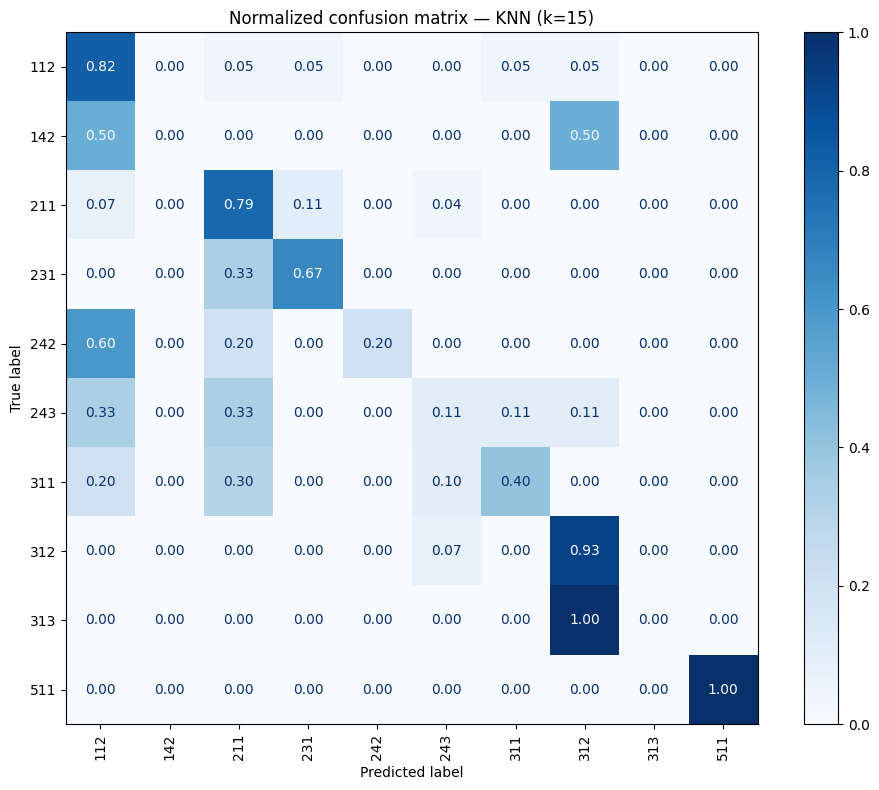

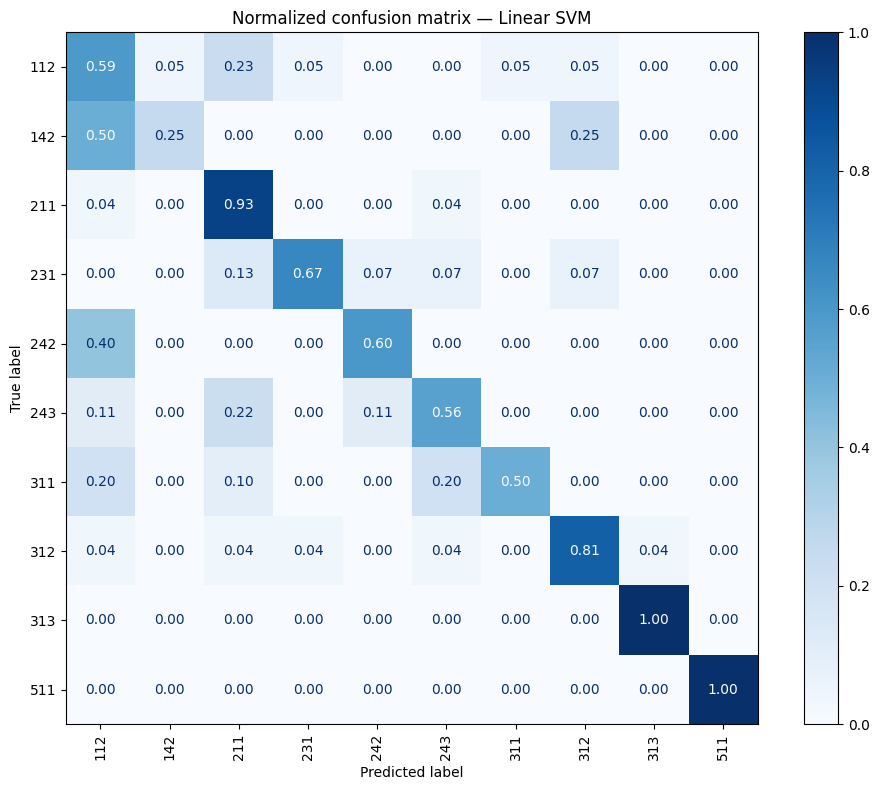

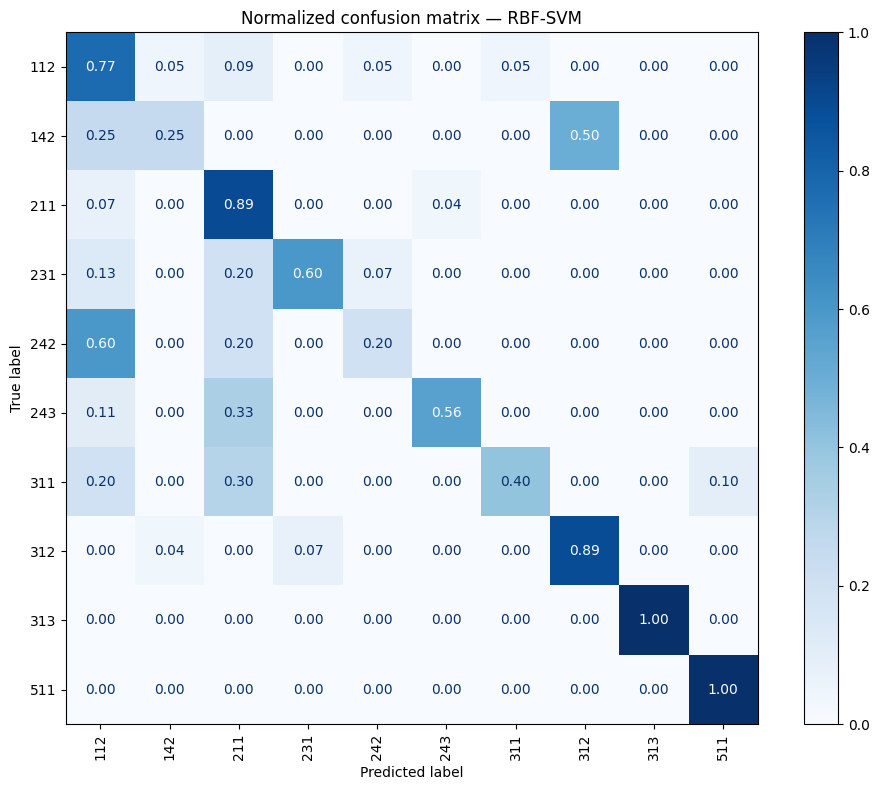

In [49]:
class_labels = np.sort(np.unique(y_test))

for name, pipe in models.items():
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=class_labels, normalize="true")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap="Blues", values_format=".2f", colorbar=True)
    ax.set_title(f"Normalized confusion matrix — {name}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


In [50]:
best_name = results_df.loc[0, "model"]
best_model = models[best_name]

print("Best model:", best_name)
print(results_df)


Best model: RBF-SVM
        model  accuracy  macro_f1
0     RBF-SVM  0.748148  0.674843
1  Linear SVM  0.740741  0.672912
2  KNN (k=15)  0.703704  0.493376


In [52]:
arr = geemap.ee_to_numpy(
    emb_img.select(emb_cols),
    region=AOI,
    scale=SCALE
)

print("Downloaded array shape:", None if arr is None else arr.shape)


Downloaded array shape: (43, 168, 64)


Saved: habitat_pl_corine_RBF_SVM.tif


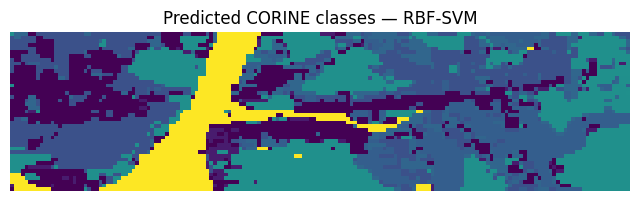

In [53]:
if arr is None:
    raise ValueError("ee_to_numpy returned None. AOI may be too large or empty.")

H, W, B = arr.shape
flat = arr.reshape(-1, B)

valid_mask = np.isfinite(flat).all(axis=1)

pred = np.full((flat.shape[0],), -9999, dtype=np.int32)
pred[valid_mask] = best_model.predict(flat[valid_mask]).astype(np.int32)

pred_img = pred.reshape(H, W)

bounds = AOI.bounds().getInfo()
coords = bounds["coordinates"][0]
xs = [p[0] for p in coords]
ys = [p[1] for p in coords]
minx, maxx = min(xs), max(xs)
miny, maxy = min(ys), max(ys)

transform = from_origin(minx, maxy, SCALE, SCALE)

out_tif = f"habitat_pl_corine_{best_name.replace(' ', '_').replace('(', '').replace(')', '').replace('-', '_')}.tif"

with rasterio.open(
    out_tif,
    "w",
    driver="GTiff",
    height=H,
    width=W,
    count=1,
    dtype=pred_img.dtype,
    transform=transform,
    nodata=-9999
) as dst:
    dst.write(pred_img, 1)


print("Saved:", out_tif)

plt.figure(figsize=(8, 6))
plt.imshow(pred_img)
plt.title(f"Predicted CORINE classes — {best_name}")
plt.axis("off")
plt.show()


In [71]:

# Ortofoto (Sentinel-2 RGB) z okresu 2024-01-01 .. 2025-01-01, przycięte do AOI
s2_rgb = (ee.ImageCollection("COPERNICUS/S2_SR")
          .filterDate("2024-01-01", "2025-01-01")
          .filterBounds(AOI)
          .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))
          .select(["B4", "B3", "B2"]))

m = geemap.Map()
m.centerObject(AOI, 13)

# Wyświetlenie samej ortofotomapy (RGB)
m.addLayer(s2_rgb, {"min": 0, "max": 3000}, "S2 RGB 2024-2025 (AOI)")

aoi_outline = ee.FeatureCollection([ee.Feature(AOI)]).style(
    color='red',
    fillColor='00000000',  # zero fill
    width=2
)

m.addLayer(aoi_outline, {}, "AOI")
m

Map(center=[52.47834885154262, 21.09426150000052], controls=(WidgetControl(options=['position', 'transparent_b…